# SOTA Model: Transfer Learning

### Import Libraries

##### Suppress Warnings

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from keras.utils import to_categorical

import matplotlib.pyplot as plt

import seaborn as sns

## Data

#### Read Whole Data

In [ ]:
dataset = pd.read_csv('Dataset/final_dataset_volume_1.csv')

features = dataset.iloc[:, :-1]
labels = dataset.iloc[:,-1]

#### Prepare/Save Train+Test Data

In [ ]:
n_classes = 9
categorical_labels = to_categorical(labels, num_classes=n_classes, dtype ="int32")

# Reshape the input data into a 3D tensor to use as input for LSTM
n_samples = features.shape[0]
n_timesteps = 15  # flattened 15 rows to one feature
n_features = 75  # 3 sensor readings for each of 25 joints
X = features.values.reshape(n_samples, n_timesteps, n_features)

# split the data into training and testing sets
dr = 'TrainTestData/'

if all(os.path.exists(dr + path) for path in ['X_train_data.npy', 'X_test_data.npy', 'y_train_data.npy', 'y_test_data.npy']):
    print('Loading existing train and test data')
    X_train = np.load(dr + 'X_train_data.npy')
    X_test  = np.load(dr + 'X_test_data.npy')
    y_train = np.load(dr + 'y_train_data.npy')
    y_test  = np.load(dr + 'y_test_data.npy')
else:
    print('Creating new train and test data')
    X_train, X_test, y_train, y_test = train_test_split(X, categorical_labels, test_size=0.2)
    np.save(dr + 'X_train_data.npy', X_train)
    np.save(dr + 'X_test_data.npy' , X_test)
    np.save(dr + 'y_train_data.npy', y_train)
    np.save(dr + 'y_test_data.npy' , y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, sep='\n')

Loading existing train and test data
(26150, 15, 75)
(6538, 15, 75)
(26150, 9)
(6538, 9)


## Creating New Model from Pretrained LSTM Model

### Load Pretrained Model

In [ ]:
# If saved model exists, load model
print('Loading saved model weights for pretrained model')
pretrained_model = tf.keras.models.load_model('cs3244_project2_lstm_model.h5')

Loading saved model weights


In [ ]:
transfer_learning_model = None
if os.path.exists('cs3244_project2_transfer_learning_model.h5'):
    # If saved model exists, load model
    print('Loading saved model weights')
    transfer_learning_model = tf.keras.models.load_model('cs3244_project2_transfer_learning_model.h5')
    print("Skip to section 'Model Training' or 'Model Prediction'")
else:
    print('No saved model weights found')
    print('Create and train a new model')

Loading saved model weights
Skip to section 'Model Training' or 'Model Prediction'


In [ ]:
pretrained_model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 512)               1204224   
                                                                 
 hidden-1 (Dense)            (None, 512)               262656    
                                                                 
 hidden-2 (Dense)            (None, 256)               131328    
                                                                 
 dense_31 (Dense)            (None, 9)                 2313      
                                                                 
Total params: 1,600,521
Trainable params: 1,600,521
Non-trainable params: 0
_________________________________________________________________


### Apply Transfer Learning

In [ ]:
# Remove the last (output) layer
pretrained_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[-2].output)
pretrained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31_input (InputLayer)  [(None, 15, 75)]          0         
                                                                 
 lstm_31 (LSTM)              (None, 512)               1204224   
                                                                 
 hidden-1 (Dense)            (None, 512)               262656    
                                                                 
 hidden-2 (Dense)            (None, 256)               131328    
                                                                 
Total params: 1,598,208
Trainable params: 1,598,208
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Do not train pretrained model layers
pretrained_model.trainable = False

# Create new LSTM model as an example only
# Add one more Dense layer to train
new_lstm = Sequential([
    pretrained_model,
    Dense(units=256, activation='relu'),  # new layer
    Dense(units=n_classes, activation='softmax')
])

# Visualize the model layers
new_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 256)               1598208   
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 1,666,313
Trainable params: 68,105
Non-trainable params: 1,598,208
_________________________________________________________________


### Hyperparameter Tuning

In [ ]:
def create_lstm_model_from_pretrained(dense_units, activation):
    pretrained_model.trainable = False

    new_lstm = Sequential([
        pretrained_model,
        Dense(units=dense_units, activation=activation),  # new layer to train
        Dense(units=n_classes, activation='softmax')
    ])
    
    return new_lstm

In [ ]:
def test_hyperparameters(loss_grid, acc_grid, dense_units, activation, num_folds=5, verbose=1):
    print(f'Testing hyperparameters [{dense_units=}] and [{activation=}]')

    sum_loss, sum_acc = 0, 0
    skf = StratifiedKFold(n_splits=num_folds)
    folds = skf.split(X_train, np.argmax(y_train, axis=1))

    for i, (train_idx, val_idx) in enumerate(folds):
        _X_train, _X_val = X_train[train_idx], X_train[val_idx]
        _y_train, _y_val = y_train[train_idx], y_train[val_idx]

        # Get and fit new LSTM model
        model = create_lstm_model_from_pretrained(dense_units, activation)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(_X_train, _y_train, epochs=5, batch_size=32, verbose=verbose)
    
        loss, acc = model.evaluate(_X_val, _y_val, verbose=0)
        sum_loss += loss
        sum_acc += acc

        print(f'Fold {i + 1} | Loss = {loss} | Accuracy = {acc}')
        print('-----------------------------------------------------------------')

    mean_loss = sum_loss / num_folds
    mean_acc = sum_acc / num_folds

    act_name = 'leaky_relu' if isinstance(activation, LeakyReLU) else activation
    loss_grid[(dense_units, act_name)] = mean_loss
    acc_grid[(dense_units, act_name)] = mean_acc

    print(f'Hyperparameters [{(dense_units, act_name)=}] | Mean Loss = {mean_loss} | Mean Accuracy = {mean_acc}\n')

In [ ]:
loss_grid = {}
acc_grid = {}

In [ ]:
dense_units = [64, 128, 256]
activations = ['relu', 'sigmoid', 'tanh', LeakyReLU(alpha=0.01)]
for i, j in np.ndindex(3, 4):
    unit, act = dense_units[i], activations[j]
    test_hyperparameters(loss_grid, acc_grid, unit, act, verbose=0)

Testing hyperparameters [dense_units=64] and [activation='relu']
Fold 1 | Loss = 0.018405156210064888 | Accuracy = 0.9933078289031982
-----------------------------------------------------------------
Fold 2 | Loss = 0.018099091947078705 | Accuracy = 0.9950286746025085
-----------------------------------------------------------------
Fold 3 | Loss = 0.01836026832461357 | Accuracy = 0.994072675704956
-----------------------------------------------------------------
Fold 4 | Loss = 0.02329285815358162 | Accuracy = 0.9919694066047668
-----------------------------------------------------------------
Fold 5 | Loss = 0.017790446057915688 | Accuracy = 0.9942638874053955
-----------------------------------------------------------------
Hyperparameters [(dense_units, act_name)=(64, 'relu')] | Mean Loss = 0.019189564138650896 | Mean Accuracy = 0.993728494644165

Testing hyperparameters [dense_units=64] and [activation='sigmoid']
Fold 1 | Loss = 0.020521309226751328 | Accuracy = 0.9936902523040771

IndexError: list index out of range

## Analyze Results

### Table of Accuracy/Loss of all Hyperparameters 

In [ ]:
units, activations = [], []
for u, act in loss_grid.keys():
    units.append(u)
    activations.append(act)

table = {
    'Hyperparameter': list(loss_grid.keys()),
    'Dense Units': units,
    'Activation': activations,
    'Loss': list(loss_grid.values()),
    'Accuracy': list(acc_grid.values())
}

df = pd.DataFrame(table)

# Save for later use
df.to_csv('Hyperparameter/transfer_learning_loss_acc_scores.csv')

# Print table
df

,Hyperparameter,Dense Units,Activation,Loss,Accuracy
0,"(64, relu)",64,relu,0.019190,0.993728
1,"(64, sigmoid)",64,sigmoid,0.021980,0.993308
2,"(64, tanh)",64,tanh,0.020494,0.993040
3,"(64, leaky_relu)",64,leaky_relu,0.020970,0.993155
4,"(128, relu)",128,relu,0.020437,0.993537
5,"(128, sigmoid)",128,sigmoid,0.019906,0.993920
6,"(128, tanh)",128,tanh,0.019151,0.993767
7,"(128, leaky_relu)",128,leaky_relu,0.021090,0.992811
8,"(256, relu)",256,relu,0.020636,0.993117
9,"(256, sigmoid)",256,sigmoid,0.021535,0.992620


### Plot of Accuracy/Loss of all Hyperparameters

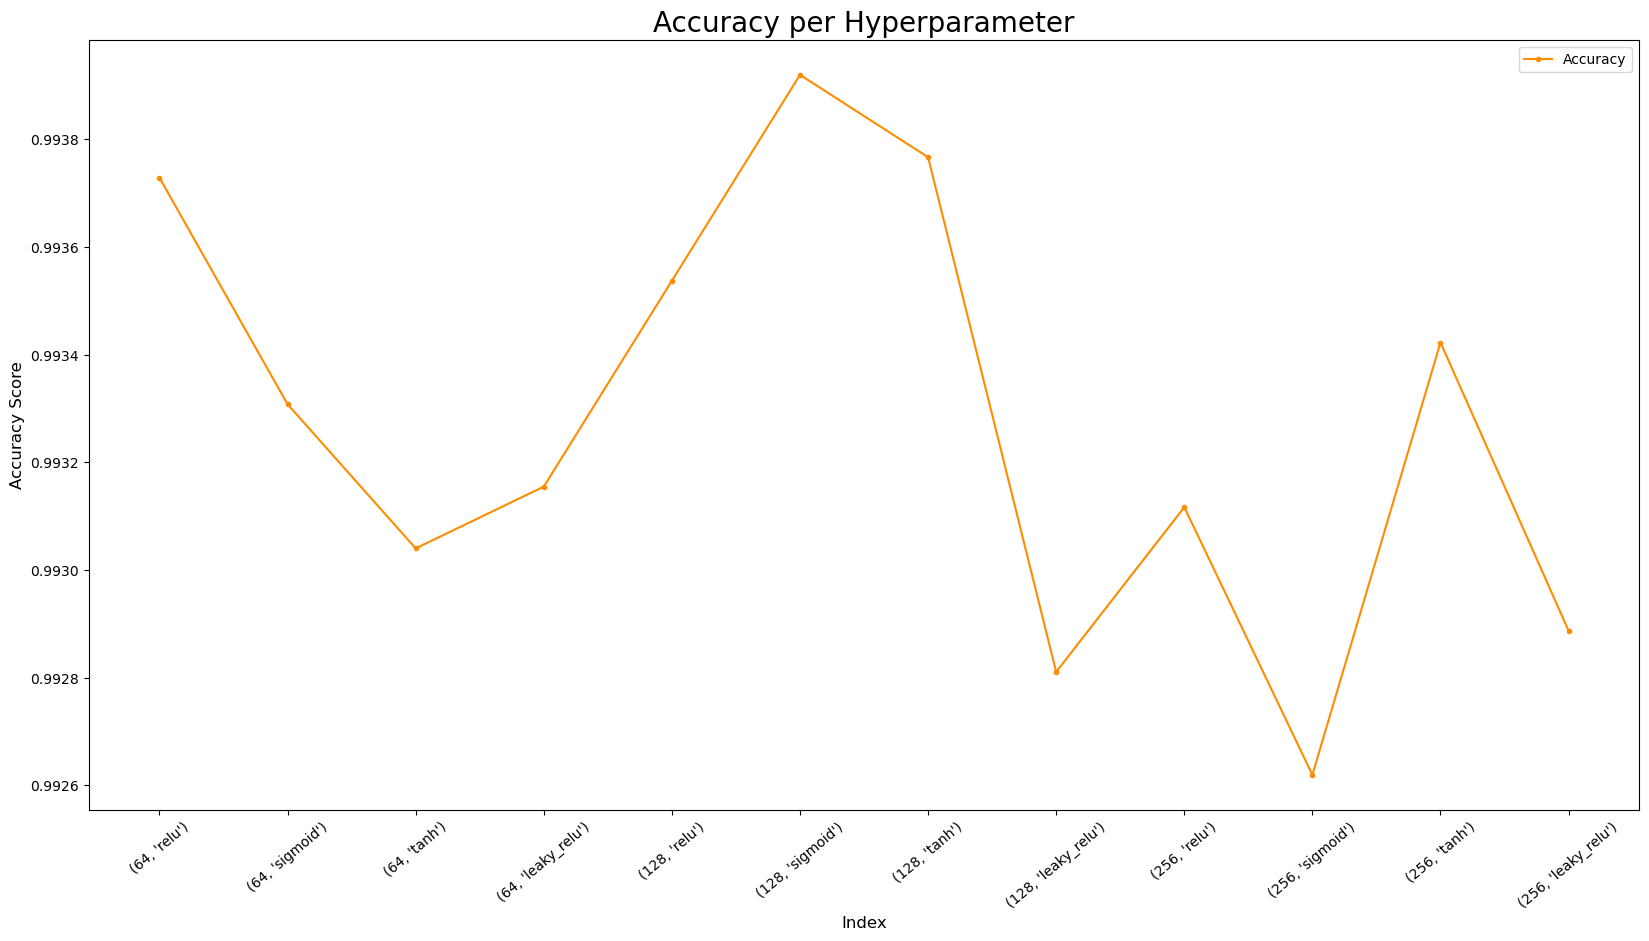

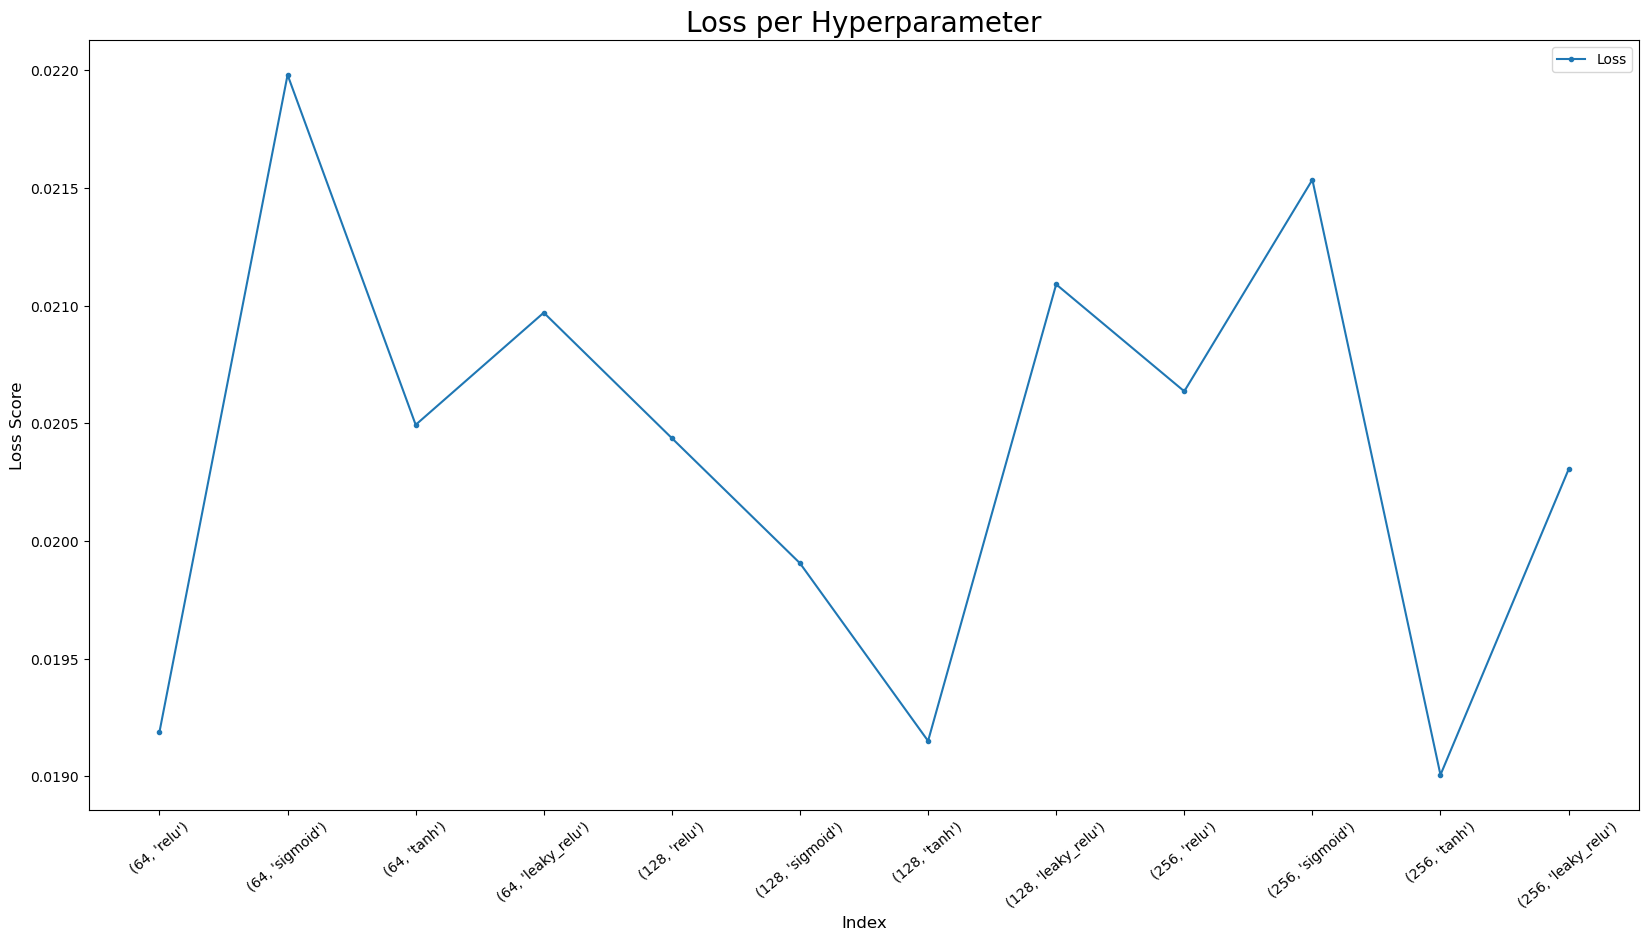

In [ ]:
x_axis = list(map(str, loss_grid.keys()))

# Plot Accuracy scores
plt.figure(figsize=(20, 10))
plt.plot(range(12), acc_grid.values(), '.-', color='darkorange', label='Accuracy')
plt.title('Accuracy per Hyperparameter', fontsize=20)
plt.xticks(range(12), x_axis, rotation=40)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.legend()
plt.show()

# Plot Loss scores
plt.figure(figsize=(20, 10))
plt.plot(range(12), loss_grid.values(), '.-', label='Loss')
plt.title('Loss per Hyperparameter', fontsize=20)
plt.xticks(range(12), x_axis, rotation=40)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Loss Score', fontsize=12)
plt.legend()
plt.show()

<Figure size 8000x4000 with 0 Axes>

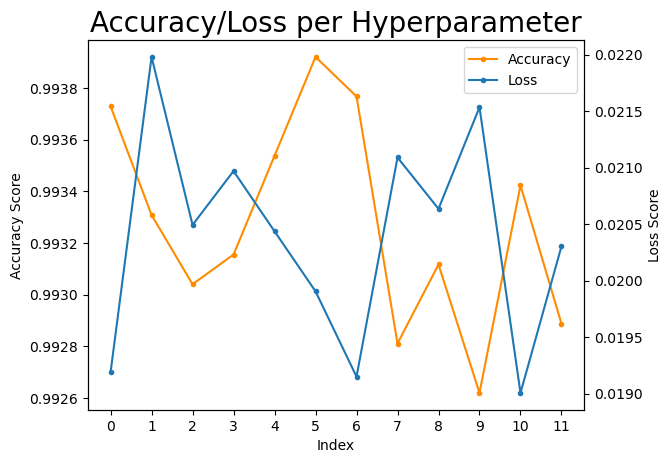

In [ ]:
x_axis = list(map(str, loss_grid.keys()))

fig = plt.figure(figsize=(80, 40))
_, ax1 = plt.subplots()
ax1.plot(range(12), acc_grid.values(), '.-', color='darkorange', label='Accuracy')
ax2 = ax1.twinx()
ax2.plot(range(12), loss_grid.values(), '.-', label='Loss')
plt.title('Accuracy/Loss per Hyperparameter', fontsize=20)
ax1.set_xlabel('Index')
ax1.set_ylabel('Accuracy Score')
ax2.set_ylabel('Loss Score')
plt.xticks(range(12), range(12))
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()

In [ ]:
df.sort_values(['Accuracy', 'Loss'], ascending=[0, 1])

,Hyperparameter,Dense Units,Activation,Loss,Accuracy
5,"(128, sigmoid)",128,sigmoid,0.019906,0.993920
6,"(128, tanh)",128,tanh,0.019151,0.993767
0,"(64, relu)",64,relu,0.019190,0.993728
4,"(128, relu)",128,relu,0.020437,0.993537
10,"(256, tanh)",256,tanh,0.019007,0.993423
1,"(64, sigmoid)",64,sigmoid,0.021980,0.993308
3,"(64, leaky_relu)",64,leaky_relu,0.020970,0.993155
8,"(256, relu)",256,relu,0.020636,0.993117
2,"(64, tanh)",64,tanh,0.020494,0.993040
11,"(256, leaky_relu)",256,leaky_relu,0.020304,0.992887


Therefore, `dense_units=128` and `activation='sigmoid'` were chosen as hyperparameters of our new LSTM model.

### Model Training

In [ ]:
# Train the LSTM model with the best set of hyperparameters found
dense_units, activation = 128, 'sigmoid'

# Create model
transfer_learning_model = create_lstm_model_from_pretrained(dense_units, activation)
transfer_learning_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='loss', patience=2, restore_best_weights=True, verbose=1), 
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, min_lr=0.00001, cooldown=2, min_delta=0.001)
]

transfer_learning_model.fit(X_train, y_train, epochs=35, batch_size=32, callbacks=callbacks)

Epoch 1/35
818/818 [==============================] - 16s 18ms/step - loss: 0.9244 - accuracy: 0.9151 - lr: 0.0010
Epoch 2/35
818/818 [==============================] - 15s 18ms/step - loss: 0.1097 - accuracy: 0.9790 - lr: 0.0010
Epoch 3/35
818/818 [==============================] - 15s 19ms/step - loss: 0.0871 - accuracy: 0.9785 - lr: 0.0010
Epoch 4/35
818/818 [==============================] - 15s 19ms/step - loss: 0.0735 - accuracy: 0.9803 - lr: 0.0010
Epoch 5/35
818/818 [==============================] - 15s 19ms/step - loss: 0.0765 - accuracy: 0.9799 - lr: 0.0010
Epoch 6/35
818/818 [==============================] - 16s 20ms/step - loss: 0.0809 - accuracy: 0.9784 - lr: 0.0010
Epoch 6: early stopping


In [ ]:
transfer_learning_model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_31 (Sequential)  (None, 9)                 1600521   
                                                                 
 dense_52 (Dense)            (None, 128)               1280      
                                                                 
 dense_53 (Dense)            (None, 9)                 1161      
                                                                 
Total params: 1,602,962
Trainable params: 2,441
Non-trainable params: 1,600,521
_________________________________________________________________


### Save Model Weights

In [ ]:
transfer_learning_model.save('cs3244_project2_transfer_learning_model.h5')

### Model Prediction

In [ ]:
pred = transfer_learning_model.predict(X_test)

205/205 [==============================] - 3s 15ms/step


### Model Accuracy (against Test Data)

In [ ]:
score = transfer_learning_model.evaluate(X_test, y_test, verbose=0)
print(f'Model Loss: {score[0]}')
print(f'Model Accuracy: {score[1]}')

Model Loss: 0.05633430927991867
Model Accuracy: 0.9854695796966553


### Other Evaluation Metrics

In [ ]:
# Decode one-hot encoded vectors to a single integer value (i.e., the index)
# e.g., [1, 0, 0, 0, 0] -> [0]
#       [0, 0, 1, 0, 0] -> [2]
pred_1d = tf.argmax(pred, axis=1)
y_test_1d = tf.argmax(y_test, axis=1)

#### Micro-Average

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test_1d, pred_1d, average='micro')
print('Micro-Average Scores:')
print(f'Precision: {precision}')
print(f'Recall   : {recall}')
print(f'F1       : {f1}')

Micro-Average Scores:
Precision: 0.985469562557357
Recall   : 0.985469562557357
F1       : 0.985469562557357


#### Macro-Average

In [ ]:
# Get scores for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test_1d, pred_1d)
avg = lambda arr: sum(arr) / len(arr)
print('Macro-Average Scores:')
print(f'Precision: {avg(precision)}')
print(f'Recall   : {avg(recall)}')
print(f'F1       : {avg(f1)}\n')

# Show scores for each class as a table
np_metrics = np.column_stack([precision, recall, f1])
pd_metrics = pd.DataFrame(np_metrics, columns=['Precision', 'Recall', 'F1'])
print('Metrics per class')
pd_metrics

Macro-Average Scores:
Precision: 0.985683535064184
Recall   : 0.9856569730100002
F1       : 0.9856504916045795

Metrics per class


,Precision,Recall,F1
0,0.978638,0.987871,0.983233
1,0.994406,0.980690,0.987500
2,0.973154,0.964096,0.968604
3,0.987500,0.979339,0.983402
4,0.977454,0.986613,0.982012
5,0.983170,0.990113,0.986629
6,1.000000,1.000000,1.000000
7,0.985095,0.995890,0.990463
8,0.991736,0.986301,0.989011


#### Confusion Matrix

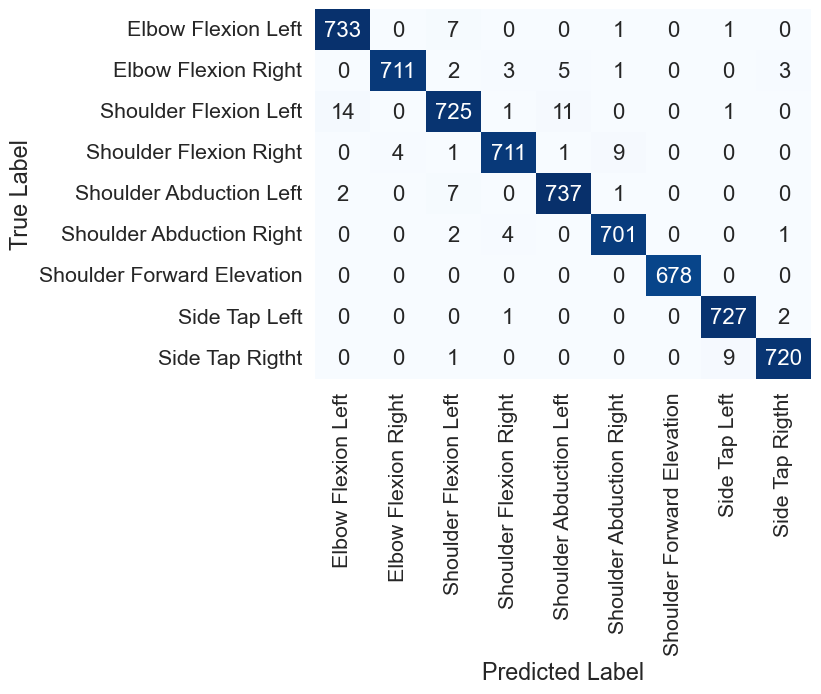

In [ ]:
gestureLabels = ['Elbow Flexion Left', 'Elbow Flexion Right', 'Shoulder Flexion Left', 'Shoulder Flexion Right',
                 'Shoulder Abduction Left', 'Shoulder Abduction Right', 'Shoulder Forward Elevation',
                 'Side Tap Left', 'Side Tap Rigtht']

label_map = {i: label for i, label in enumerate(gestureLabels)}
labels = [label_map[i] for i in range(len(label_map))]

# Create confusion matrix
cm = confusion_matrix(y_test_1d, pred_1d)

# Plot confusion matrix as heatmap
sns.set(font_scale=1.4) # Adjust font size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)

# Set plot labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()